In [ ]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, gaussian_laplace, zoom

X = []

# ---------------------------
# Upsample and Estimate Sigma
# ---------------------------

def upsample_patch(patch, scale=2):
    return zoom(patch, zoom=scale, order=1)

def estimate_sigma_by_LoG(patch_up, sigma_range=np.arange(0.8, 5.0, 0.2)):
    max_response = -np.inf
    best_sigma = 1.0
    for sigma in sigma_range:
        log_response = gaussian_laplace(patch_up, sigma=sigma)
        response_strength = np.abs(log_response).max()
        if response_strength > max_response:
            max_response = response_strength
            best_sigma = sigma
    return best_sigma

# ---------------------------
# Dynamic ROI extraction
# ---------------------------

def extract_dynamic_rois(swi_data, coordinates, init_patch_size=24, scale=2):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        x_start = max(0, x - init_patch_size // 2)
        x_end = min(swi_data.shape[0], x + (init_patch_size + 1) // 2)
        y_start = max(0, y - init_patch_size // 2)
        y_end = min(swi_data.shape[1], y + (init_patch_size + 1) // 2)
        z_start = max(0, z - init_patch_size // 2)
        z_end = min(swi_data.shape[2], z + (init_patch_size + 1) // 2)

        roi_init = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        roi_up = upsample_patch(roi_init, scale=scale)
        sigma = estimate_sigma_by_LoG(roi_up)

        roi_size = int(round(6 * sigma / scale))
        roi_size = max(roi_size, 6)

        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)

        final_roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(final_roi)
    return rois

# ---------------------------
# Hessian Features
# ---------------------------

def compute_hessian_eigenvalues(roi, sigma=2.5):
    smoothed = gaussian_filter(roi, sigma=sigma)
    Ixx = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(2, 0, 0))
    Iyy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 2, 0))
    Izz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 0, 2))
    Ixy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 1, 0))
    Ixz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 0, 1))
    Iyz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 1, 1))

    H = sigma**2 * np.array([
        [Ixx.mean(), Ixy.mean(), Ixz.mean()],
        [Ixy.mean(), Iyy.mean(), Iyz.mean()],
        [Ixz.mean(), Iyz.mean(), Izz.mean()]
    ])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        return 0, 0, 0
    ev = np.sort(np.abs(eigenvalues))
    f_sphere = ev[0] / np.sqrt(ev[1] * ev[2]) if ev[1]*ev[2] != 0 else 0
    f_lc = ev[1] / ev[2] if ev[2] != 0 else 0
    denom = np.sqrt(ev[0]**2 + ev[1]**2 + ev[2]**2)
    num = np.sqrt(0.5 * ((ev[0]-ev[1])**2 + (ev[1]-ev[2])**2 + (ev[0]-ev[2])**2))
    f_fa = num / denom if denom != 0 else 0
    return f_sphere, f_lc, f_fa

# ---------------------------
# Radon-like shape features
# ---------------------------
import matplotlib.pyplot as plt

def visualize_roi(roi, title='ROI'):
    mid_x = roi.shape[0] // 2
    mid_y = roi.shape[1] // 2
    mid_z = roi.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(roi[mid_x, :, :], cmap='gray')
    axes[0].set_title(f'{title} - Axial (X mid)')
    axes[0].axis('off')

    axes[1].imshow(roi[:, mid_y, :], cmap='gray')
    axes[1].set_title(f'{title} - Coronal (Y mid)')
    axes[1].axis('off')

    axes[2].imshow(roi[:, :, mid_z], cmap='gray')
    axes[2].set_title(f'{title} - Sagittal (Z mid)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()



def compute_radon_features(rois):
    radon_features = []
    for roi in rois:
        proj_xy = np.sum(roi, axis=2)
        proj_xz = np.sum(roi, axis=1)
        proj_yz = np.sum(roi, axis=0)

        mean_xy = np.mean(proj_xy)
        mean_xz = np.mean(proj_xz)
        mean_yz = np.mean(proj_yz)

        std_xy = np.std(proj_xy)
        std_xz = np.std(proj_xz)
        std_yz = np.std(proj_yz)

        radon_features.append([mean_xy, std_xy, mean_xz, std_xz, mean_yz, std_yz])
    return np.array(radon_features)

# ---------------------------
# Load Excel and Loop Images
# ---------------------------

excel_file = 'sCMB_yes.xlsx'
df = pd.read_excel(excel_file)
folder_path = 'filtered_data'

for index, row in df.iterrows():
    nifti_filename = row['NIFTI']
    nifti_path = os.path.join(folder_path, nifti_filename)

    if not os.path.exists(nifti_path):
        continue

    swi_img = nib.load(nifti_path)
    swi_data = swi_img.get_fdata()

    microbleed_coordinates = []
    for i in range(1, len(row), 3):
        try:
            if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                x = int(row.iloc[i])
                y = int(row.iloc[i+1])
                z = int(row.iloc[i+2])
                microbleed_coordinates.append((x, y, z))
        except (ValueError, TypeError, IndexError):
            continue

    # Extract dynamic ROIs
    microbleed_rois = extract_dynamic_rois(swi_data, microbleed_coordinates)

        # VISUALIZE first few ROIs
    for i, roi in enumerate(microbleed_rois[:3]):  # visualize first 3 for example
        title = f'Subject {index+1}, ROI {i+1}'
        visualize_roi(roi, title=title)

    # Compute Radon features
    radon_features_microbleed = compute_radon_features(microbleed_rois)

    # Compute Hessian shape features
    hessian_shape_features_microbleed = []
    for roi in microbleed_rois:
        eigenvals, _ = compute_hessian_eigenvalues(roi)
        hessian_features = compute_hessian_shape_features(eigenvals)
        hessian_shape_features_microbleed.append(np.array(hessian_features))

    # Combine features
    for coord, radon_feat, hessian_feat in zip(microbleed_coordinates, radon_features_microbleed, hessian_shape_features_microbleed):
        combined = np.concatenate((radon_feat, hessian_feat))
        X.append(combined)

# --------------------------------
# Final Output
# --------------------------------

X1 = np.array(X)
print("Feature matrix shape:", X1.shape)
print(X1)

In [3]:
# Determine the number of microbleeds in X
num_microbleeds = X1.shape[0]

# Set the labels for microbleeds as 1
Y1 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y1.shape}")

# Display a few labels to confirm
print(Y1)

Shape of Y0 (labels): (3130,)
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, gaussian_laplace, zoom

X = []

# ---------------------------
# Upsample and Estimate Sigma
# ---------------------------

def upsample_patch(patch, scale=2):
    return zoom(patch, zoom=scale, order=1)

def estimate_sigma_by_LoG(patch_up, sigma_range=np.arange(0.8, 5.0, 0.2)):
    max_response = -np.inf
    best_sigma = 1.0
    for sigma in sigma_range:
        log_response = gaussian_laplace(patch_up, sigma=sigma)
        response_strength = np.abs(log_response).max()
        if response_strength > max_response:
            max_response = response_strength
            best_sigma = sigma
    return best_sigma

# ---------------------------
# Dynamic ROI extraction
# ---------------------------

def extract_dynamic_rois(swi_data, coordinates, init_patch_size=24, scale=2):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        x_start = max(0, x - init_patch_size // 2)
        x_end = min(swi_data.shape[0], x + (init_patch_size + 1) // 2)
        y_start = max(0, y - init_patch_size // 2)
        y_end = min(swi_data.shape[1], y + (init_patch_size + 1) // 2)
        z_start = max(0, z - init_patch_size // 2)
        z_end = min(swi_data.shape[2], z + (init_patch_size + 1) // 2)

        roi_init = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        roi_up = upsample_patch(roi_init, scale=scale)
        sigma = estimate_sigma_by_LoG(roi_up)

        roi_size = int(round(6 * sigma / scale))
        roi_size = max(roi_size, 6)

        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)

        final_roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(final_roi)
    return rois

# ---------------------------
# Hessian Features
# ---------------------------

def compute_hessian_eigenvalues(roi, sigma=2.5):
    smoothed = gaussian_filter(roi, sigma=sigma)
    Ixx = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(2, 0, 0))
    Iyy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 2, 0))
    Izz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 0, 2))
    Ixy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 1, 0))
    Ixz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 0, 1))
    Iyz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 1, 1))

    H = sigma**2 * np.array([
        [Ixx.mean(), Ixy.mean(), Ixz.mean()],
        [Ixy.mean(), Iyy.mean(), Iyz.mean()],
        [Ixz.mean(), Iyz.mean(), Izz.mean()]
    ])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        return 0, 0, 0
    ev = np.sort(np.abs(eigenvalues))
    f_sphere = ev[0] / np.sqrt(ev[1] * ev[2]) if ev[1]*ev[2] != 0 else 0
    f_lc = ev[1] / ev[2] if ev[2] != 0 else 0
    denom = np.sqrt(ev[0]**2 + ev[1]**2 + ev[2]**2)
    num = np.sqrt(0.5 * ((ev[0]-ev[1])**2 + (ev[1]-ev[2])**2 + (ev[0]-ev[2])**2))
    f_fa = num / denom if denom != 0 else 0
    return f_sphere, f_lc, f_fa

# ---------------------------
# Radon-like shape features
# ---------------------------
import matplotlib.pyplot as plt

def visualize_roi(roi, title='ROI'):
    mid_x = roi.shape[0] // 2
    mid_y = roi.shape[1] // 2
    mid_z = roi.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(roi[mid_x, :, :], cmap='gray')
    axes[0].set_title(f'{title} - Axial (X mid)')
    axes[0].axis('off')

    axes[1].imshow(roi[:, mid_y, :], cmap='gray')
    axes[1].set_title(f'{title} - Coronal (Y mid)')
    axes[1].axis('off')

    axes[2].imshow(roi[:, :, mid_z], cmap='gray')
    axes[2].set_title(f'{title} - Sagittal (Z mid)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()



def compute_radon_features(rois):
    radon_features = []
    for roi in rois:
        proj_xy = np.sum(roi, axis=2)
        proj_xz = np.sum(roi, axis=1)
        proj_yz = np.sum(roi, axis=0)

        mean_xy = np.mean(proj_xy)
        mean_xz = np.mean(proj_xz)
        mean_yz = np.mean(proj_yz)

        std_xy = np.std(proj_xy)
        std_xz = np.std(proj_xz)
        std_yz = np.std(proj_yz)

        radon_features.append([mean_xy, std_xy, mean_xz, std_xz, mean_yz, std_yz])
    return np.array(radon_features)

# ---------------------------
# Load Excel and Loop Images
# ---------------------------

# Load coordinates
excel_file = 'scmb_filteredV6_output.xlsx'
df = pd.read_excel(excel_file)
folder_path = 'Scmb-non'


for index, row in df.iterrows():
    nifti_filename = row['NIFTI']
    nifti_path = os.path.join(folder_path, nifti_filename)

    if not os.path.exists(nifti_path):
        continue

    swi_img = nib.load(nifti_path)
    swi_data = swi_img.get_fdata()

    microbleed_coordinates = []
    for i in range(1, len(row), 3):
        try:
            if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                x = int(row.iloc[i])
                y = int(row.iloc[i+1])
                z = int(row.iloc[i+2])
                microbleed_coordinates.append((x, y, z))
        except (ValueError, TypeError, IndexError):
            continue

    # Extract dynamic ROIs
    microbleed_rois = extract_dynamic_rois(swi_data, microbleed_coordinates)

        # VISUALIZE first few ROIs
    for i, roi in enumerate(microbleed_rois[:3]):  # visualize first 3 for example
        title = f'Subject {index+1}, ROI {i+1}'
        visualize_roi(roi, title=title)

    # Compute Radon features
    radon_features_microbleed = compute_radon_features(microbleed_rois)

    # Compute Hessian shape features
    hessian_shape_features_microbleed = []
    for roi in microbleed_rois:
        eigenvals, _ = compute_hessian_eigenvalues(roi)
        hessian_features = compute_hessian_shape_features(eigenvals)
        hessian_shape_features_microbleed.append(np.array(hessian_features))

    # Combine features
    for coord, radon_feat, hessian_feat in zip(microbleed_coordinates, radon_features_microbleed, hessian_shape_features_microbleed):
        combined = np.concatenate((radon_feat, hessian_feat))
        X.append(combined)

# ---------------------------
# Final Output
# ---------------------------

X0 = np.array(X)
print("Feature matrix shape:", X1.shape)
print(X0)

In [ ]:
# Determine the number of microbleeds in X
num_microbleeds = X0.shape[0]

# Set the labels for microbleeds as 1
Y0 = np.zeros(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y0.shape}")

# Display a few labels to confirm
print(Y0)

Shape of Y0 (labels): (3130,)
[0. 0. 0. ... 0. 0. 0.]


In [8]:
X = np.vstack((X1,X0))
print(X.shape)
print(X)
# Create corresponding labels 'y' (1 for microbleeds, 0 for non-microbleeds)
Y = np.hstack((Y1,Y0))
print(Y.shape)
print(Y)

(6260, 9)
[[0.79653015 0.11634758 0.79653015 ... 0.20079805 0.72408129 0.58674668]
 [0.7888038  0.42460107 0.7888038  ... 0.28290741 0.97682203 0.49739114]
 [0.88819691 0.30174193 0.88819691 ... 0.56962715 0.78292335 0.3151671 ]
 ...
 [0.70739309 0.23222287 0.70739309 ... 0.69274824 0.97446846 0.19565332]
 [0.88461617 0.11785202 0.88461617 ... 0.23360353 0.8909683  0.538621  ]
 [0.84059893 0.24339777 0.84059893 ... 0.82549681 0.90656826 0.11897846]]
(6260,)
[1. 1. 1. ... 0. 0. 0.]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN / (TN + FP)
print("Specificity:", FPR)


# Save the model
with open('rf_classifier_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

Accuracy: 0.2771565495207668
Confusion Matrix:
[[243 364]
 [541 104]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.31      0.40      0.35       607
         1.0       0.22      0.16      0.19       645

    accuracy                           0.28      1252
   macro avg       0.27      0.28      0.27      1252
weighted avg       0.26      0.28      0.27      1252

Sensitivity: 0.16124031007751938
Specificity: 0.400329489291598


##### full compilation code .

In [1]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, gaussian_laplace, zoom

X = []

# ---------------------------
# Upsample and Estimate Sigma
# ---------------------------

def upsample_patch(patch, scale=2):
    return zoom(patch, zoom=scale, order=1)

def estimate_sigma_by_LoG(patch_up, sigma_range=np.arange(0.8, 5.0, 0.2)):
    max_response = -np.inf
    best_sigma = 1.0
    for sigma in sigma_range:
        log_response = gaussian_laplace(patch_up, sigma=sigma)
        response_strength = np.abs(log_response).max()
        if response_strength > max_response:
            max_response = response_strength
            best_sigma = sigma
    return best_sigma

# ---------------------------
# Dynamic ROI extraction
# ---------------------------

def extract_dynamic_rois(swi_data, coordinates, init_patch_size=24, scale=2):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        x_start = max(0, x - init_patch_size // 2)
        x_end = min(swi_data.shape[0], x + (init_patch_size + 1) // 2)
        y_start = max(0, y - init_patch_size // 2)
        y_end = min(swi_data.shape[1], y + (init_patch_size + 1) // 2)
        z_start = max(0, z - init_patch_size // 2)
        z_end = min(swi_data.shape[2], z + (init_patch_size + 1) // 2)

        roi_init = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        roi_up = upsample_patch(roi_init, scale=scale)
        sigma = estimate_sigma_by_LoG(roi_up)

        roi_size = int(round(6 * sigma / scale))
        roi_size = max(roi_size, 6)

        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)

        final_roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(final_roi)
    return rois

# ---------------------------
# Hessian Features
# ---------------------------

def compute_hessian_eigenvalues(roi, sigma=2.5):
    smoothed = gaussian_filter(roi, sigma=sigma)
    Ixx = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(2, 0, 0))
    Iyy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 2, 0))
    Izz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 0, 2))
    Ixy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 1, 0))
    Ixz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 0, 1))
    Iyz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 1, 1))

    H = sigma**2 * np.array([
        [Ixx.mean(), Ixy.mean(), Ixz.mean()],
        [Ixy.mean(), Iyy.mean(), Iyz.mean()],
        [Ixz.mean(), Iyz.mean(), Izz.mean()]
    ])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        return 0, 0, 0
    ev = np.sort(np.abs(eigenvalues))
    f_sphere = ev[0] / np.sqrt(ev[1] * ev[2]) if ev[1]*ev[2] != 0 else 0
    f_lc = ev[1] / ev[2] if ev[2] != 0 else 0
    denom = np.sqrt(ev[0]**2 + ev[1]**2 + ev[2]**2)
    num = np.sqrt(0.5 * ((ev[0]-ev[1])**2 + (ev[1]-ev[2])**2 + (ev[0]-ev[2])**2))
    f_fa = num / denom if denom != 0 else 0
    return f_sphere, f_lc, f_fa

# ---------------------------
# Radon-like shape features
# ---------------------------

def compute_radon_features(rois):
    radon_features = []
    for roi in rois:
        proj_xy = np.sum(roi, axis=2)
        proj_xz = np.sum(roi, axis=1)
        proj_yz = np.sum(roi, axis=0)

        mean_xy = np.mean(proj_xy)
        mean_xz = np.mean(proj_xz)
        mean_yz = np.mean(proj_yz)

        std_xy = np.std(proj_xy)
        std_xz = np.std(proj_xz)
        std_yz = np.std(proj_yz)

        radon_features.append([mean_xy, std_xy, mean_xz, std_xz, mean_yz, std_yz])
    return np.array(radon_features)

# ---------------------------
# Load Excel and Loop Images
# ---------------------------

excel_file = 'sCMB_yes_V1.xlsx'
df = pd.read_excel(excel_file)
folder_path = 'filtered_data'

for index, row in df.iterrows():
    nifti_filename = row['NIFTI']
    nifti_path = os.path.join(folder_path, nifti_filename)

    if not os.path.exists(nifti_path):
        continue

    swi_img = nib.load(nifti_path)
    swi_data = swi_img.get_fdata()

    microbleed_coordinates = []
    for i in range(1, len(row), 3):
        try:
            if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                x = int(row.iloc[i])
                y = int(row.iloc[i+1])
                z = int(row.iloc[i+2])
                microbleed_coordinates.append((x, y, z))
        except (ValueError, TypeError, IndexError):
            continue

    # Extract dynamic ROIs
    microbleed_rois = extract_dynamic_rois(swi_data, microbleed_coordinates)

    # Compute Radon features
    radon_features_microbleed = compute_radon_features(microbleed_rois)

    # Compute Hessian shape features
    hessian_shape_features_microbleed = []
    for roi in microbleed_rois:
        eigenvals, _ = compute_hessian_eigenvalues(roi)
        hessian_features = compute_hessian_shape_features(eigenvals)
        hessian_shape_features_microbleed.append(np.array(hessian_features))

    # Combine features
    for coord, radon_feat, hessian_feat in zip(microbleed_coordinates, radon_features_microbleed, hessian_shape_features_microbleed):
        combined = np.concatenate((radon_feat, hessian_feat))
        X.append(combined)

# --------------------------------
# Final Output
# --------------------------------

X1 = np.array(X)
print("Feature matrix shape:", X1.shape)
print(X1)

Feature matrix shape: (3130, 9)
[[2.75104985e+03 2.55102422e+02 2.75104985e+03 ... 6.56397739e-01
  4.39914129e-01 4.78195075e-01]
 [2.65697456e+03 4.31322179e+02 2.65697456e+03 ... 6.89013086e-01
  6.26056829e-01 3.23360122e-01]
 [2.72474018e+03 3.19864016e+02 2.72474018e+03 ... 2.22958394e-01
  1.80254899e-01 8.48317982e-01]
 ...
 [2.81232978e+03 2.30628867e+02 2.81232978e+03 ... 7.04923648e-02
  4.75807150e-01 7.44561893e-01]
 [2.65299255e+03 2.71602725e+02 2.65299255e+03 ... 1.69899882e-01
  7.01791614e-01 6.13166866e-01]
 [2.74666647e+03 2.77015666e+02 2.74666647e+03 ... 6.56861381e-02
  4.91907767e-01 7.41188091e-01]]


In [2]:
# Determine the number of microbleeds in X
num_microbleeds = X1.shape[0]

# Set the labels for microbleeds as 1
Y1 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y1.shape}")

# Display a few labels to confirm
print(Y1)

Shape of Y0 (labels): (3130,)
[1. 1. 1. ... 1. 1. 1.]


In [4]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, gaussian_laplace, zoom

X = []

# ---------------------------
# Upsample and Estimate Sigma
# ---------------------------

def upsample_patch(patch, scale=2):
    return zoom(patch, zoom=scale, order=1)

def estimate_sigma_by_LoG(patch_up, sigma_range=np.arange(0.8, 5.0, 0.2)):
    max_response = -np.inf
    best_sigma = 1.0
    for sigma in sigma_range:
        log_response = gaussian_laplace(patch_up, sigma=sigma)
        response_strength = np.abs(log_response).max()
        if response_strength > max_response:
            max_response = response_strength
            best_sigma = sigma
    return best_sigma

# ---------------------------
# Dynamic ROI extraction
# ---------------------------

def extract_dynamic_rois(swi_data, coordinates, init_patch_size=24, scale=2):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        x_start = max(0, x - init_patch_size // 2)
        x_end = min(swi_data.shape[0], x + (init_patch_size + 1) // 2)
        y_start = max(0, y - init_patch_size // 2)
        y_end = min(swi_data.shape[1], y + (init_patch_size + 1) // 2)
        z_start = max(0, z - init_patch_size // 2)
        z_end = min(swi_data.shape[2], z + (init_patch_size + 1) // 2)

        roi_init = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        roi_up = upsample_patch(roi_init, scale=scale)
        sigma = estimate_sigma_by_LoG(roi_up)

        roi_size = int(round(6 * sigma / scale))
        roi_size = max(roi_size, 6)

        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)

        final_roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(final_roi)
    return rois

# ---------------------------
# Hessian Features
# ---------------------------

def compute_hessian_eigenvalues(roi, sigma=2.5):
    smoothed = gaussian_filter(roi, sigma=sigma)
    Ixx = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(2, 0, 0))
    Iyy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 2, 0))
    Izz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 0, 2))
    Ixy = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 1, 0))
    Ixz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(1, 0, 1))
    Iyz = ndimage.gaussian_filter(smoothed, sigma=sigma, order=(0, 1, 1))

    H = sigma**2 * np.array([
        [Ixx.mean(), Ixy.mean(), Ixz.mean()],
        [Ixy.mean(), Iyy.mean(), Iyz.mean()],
        [Ixz.mean(), Iyz.mean(), Izz.mean()]
    ])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        return 0, 0, 0
    ev = np.sort(np.abs(eigenvalues))
    f_sphere = ev[0] / np.sqrt(ev[1] * ev[2]) if ev[1]*ev[2] != 0 else 0
    f_lc = ev[1] / ev[2] if ev[2] != 0 else 0
    denom = np.sqrt(ev[0]**2 + ev[1]**2 + ev[2]**2)
    num = np.sqrt(0.5 * ((ev[0]-ev[1])**2 + (ev[1]-ev[2])**2 + (ev[0]-ev[2])**2))
    f_fa = num / denom if denom != 0 else 0
    return f_sphere, f_lc, f_fa

# ---------------------------
# Radon-like shape features
# ---------------------------

def compute_radon_features(rois):
    radon_features = []
    for roi in rois:
        proj_xy = np.sum(roi, axis=2)
        proj_xz = np.sum(roi, axis=1)
        proj_yz = np.sum(roi, axis=0)

        mean_xy = np.mean(proj_xy)
        mean_xz = np.mean(proj_xz)
        mean_yz = np.mean(proj_yz)

        std_xy = np.std(proj_xy)
        std_xz = np.std(proj_xz)
        std_yz = np.std(proj_yz)

        radon_features.append([mean_xy, std_xy, mean_xz, std_xz, mean_yz, std_yz])
    return np.array(radon_features)

# ---------------------------
# Load Excel and Loop Images
# ---------------------------

excel_file = 'non-cmb_unmatch_V1.xlsx'
df = pd.read_excel(excel_file)
folder_path = 'filtered_data'

for index, row in df.iterrows():
    nifti_filename = row['NIFTI']
    nifti_path = os.path.join(folder_path, nifti_filename)

    if not os.path.exists(nifti_path):
        continue

    swi_img = nib.load(nifti_path)
    swi_data = swi_img.get_fdata()

    microbleed_coordinates = []
    for i in range(1, len(row), 3):
        try:
            if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                x = int(row.iloc[i])
                y = int(row.iloc[i+1])
                z = int(row.iloc[i+2])
                microbleed_coordinates.append((x, y, z))
        except (ValueError, TypeError, IndexError):
            continue
    # Extract dynamic ROIs
    microbleed_rois = extract_dynamic_rois(swi_data, microbleed_coordinates)

    # Compute Radon features
    radon_features_microbleed = compute_radon_features(microbleed_rois)

    # Compute Hessian shape features
    hessian_shape_features_microbleed = []
    for roi in microbleed_rois:
        eigenvals, _ = compute_hessian_eigenvalues(roi)
        hessian_features = compute_hessian_shape_features(eigenvals)
        hessian_shape_features_microbleed.append(np.array(hessian_features))

    # Combine features
    for coord, radon_feat, hessian_feat in zip(microbleed_coordinates, radon_features_microbleed, hessian_shape_features_microbleed):
        combined = np.concatenate((radon_feat, hessian_feat))
        X.append(combined)

# --------------------------------
# Final Output
# --------------------------------

X0 = np.array(X)
print("Feature matrix shape:", X0.shape)
print(X0)

Feature matrix shape: (3130, 9)
[[2.37473706e+03 3.05732222e+02 2.37473706e+03 ... 5.98561644e-01
  8.62925306e-01 2.74756768e-01]
 [1.32224692e+03 9.24419967e+02 1.32224692e+03 ... 7.90962862e-02
  8.54809088e-01 6.55347008e-01]
 [2.60315902e+03 2.78668923e+02 2.60315902e+03 ... 6.65050659e-01
  8.03350339e-01 2.47333206e-01]
 ...
 [2.66429499e+03 1.39709706e+02 2.66429499e+03 ... 4.14870506e-01
  3.95101089e-01 6.16466720e-01]
 [2.70811938e+03 1.19365771e+02 2.70811938e+03 ... 1.85446851e-01
  3.86510008e-01 7.28068229e-01]
 [2.15610206e+03 2.99981130e+02 2.15610206e+03 ... 2.99761291e-01
  7.00405382e-01 5.23976295e-01]]


In [5]:
# Determine the number of microbleeds in X
num_microbleeds = X0.shape[0]

# Set the labels for microbleeds as 1
Y0 = np.zeros(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y0.shape}")

# Display a few labels to confirm
print(Y0)

Shape of Y0 (labels): (3130,)
[0. 0. 0. ... 0. 0. 0.]


In [6]:
X = np.vstack((X1,X0))
print(X.shape)
print(X)
# Create corresponding labels 'y' (1 for microbleeds, 0 for non-microbleeds)
Y = np.hstack((Y1,Y0))
print(Y.shape)
print(Y)

(6260, 9)
[[2.75104985e+03 2.55102422e+02 2.75104985e+03 ... 6.56397739e-01
  4.39914129e-01 4.78195075e-01]
 [2.65697456e+03 4.31322179e+02 2.65697456e+03 ... 6.89013086e-01
  6.26056829e-01 3.23360122e-01]
 [2.72474018e+03 3.19864016e+02 2.72474018e+03 ... 2.22958394e-01
  1.80254899e-01 8.48317982e-01]
 ...
 [2.66429499e+03 1.39709706e+02 2.66429499e+03 ... 4.14870506e-01
  3.95101089e-01 6.16466720e-01]
 [2.70811938e+03 1.19365771e+02 2.70811938e+03 ... 1.85446851e-01
  3.86510008e-01 7.28068229e-01]
 [2.15610206e+03 2.99981130e+02 2.15610206e+03 ... 2.99761291e-01
  7.00405382e-01 5.23976295e-01]]
(6260,)
[1. 1. 1. ... 0. 0. 0.]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN / (TN + FP)
print("Specificity:", FPR)


# Save the model
with open('rf_classifier_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

Accuracy: 0.7859424920127795
Confusion Matrix:
[[389 218]
 [ 50 595]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.64      0.74       607
         1.0       0.73      0.92      0.82       645

    accuracy                           0.79      1252
   macro avg       0.81      0.78      0.78      1252
weighted avg       0.81      0.79      0.78      1252

Sensitivity: 0.9224806201550387
Specificity: 0.6408566721581549


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import numpy as np
import pickle

# Assuming you have X and Y defined
# Split the data into training and testing sets
X_train, X_test, y_train, y_test

# Train the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN/ (TN + FP)
print("Specificity:", FPR)

# Save the model
with open('xgb_classifier_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

Accuracy: 0.8011182108626198
Confusion Matrix:
[[451 156]
 [ 93 552]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       607
         1.0       0.78      0.86      0.82       645

    accuracy                           0.80      1252
   macro avg       0.80      0.80      0.80      1252
weighted avg       0.80      0.80      0.80      1252

Sensitivity: 0.8558139534883721
Specificity: 0.742998352553542


Accuracy: 0.8011182108626198
Confusion Matrix:
[[451 156]
 [ 93 552]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       607
         1.0       0.78      0.86      0.82       645

    accuracy                           0.80      1252
   macro avg       0.80      0.80      0.80      1252
weighted avg       0.80      0.80      0.80      1252

Sensitivity: 0.8558139534883721
Specificity: 0.742998352553542


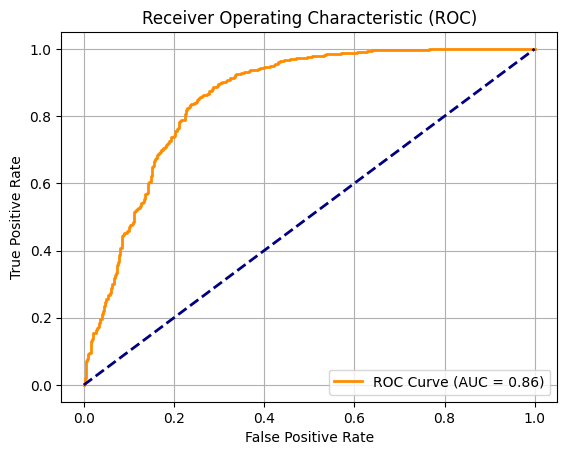

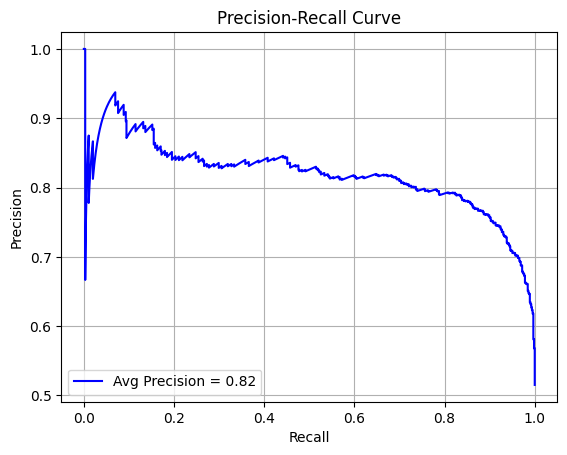

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Assuming X and Y are defined
X_train, X_test, y_train, y_test 

# Train the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)

# Predict labels
y_pred = xgb_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Sensitivity (Recall for class 1)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Specificity (True Negative Rate)
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# ROC Curve + AUC
class_index = list(xgb_classifier.classes_).index(1)  # ensure correct class used
y_probs = xgb_classifier.predict_proba(X_test)[:, class_index]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Save model
with open('xgb_classifier_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5868 - loss: 12.1416 - val_accuracy: 0.5709 - val_loss: 6.4839
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6469 - loss: 3.9614 - val_accuracy: 0.7096 - val_loss: 2.1800
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6434 - loss: 2.9856 - val_accuracy: 0.7146 - val_loss: 1.2515
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6499 - loss: 3.1044 - val_accuracy: 0.7784 - val_loss: 1.2244
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6033 - loss: 4.6493 - val_accuracy: 0.7176 - val_loss: 2.2678
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6573 - loss: 2.8659 - val_accuracy: 0.6048 - val_loss: 3.8665
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6658 - loss: 2.8056 - val_accuracy: 0.6158 - val_loss: 1.9238
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6686 - loss: 2.9903 - va

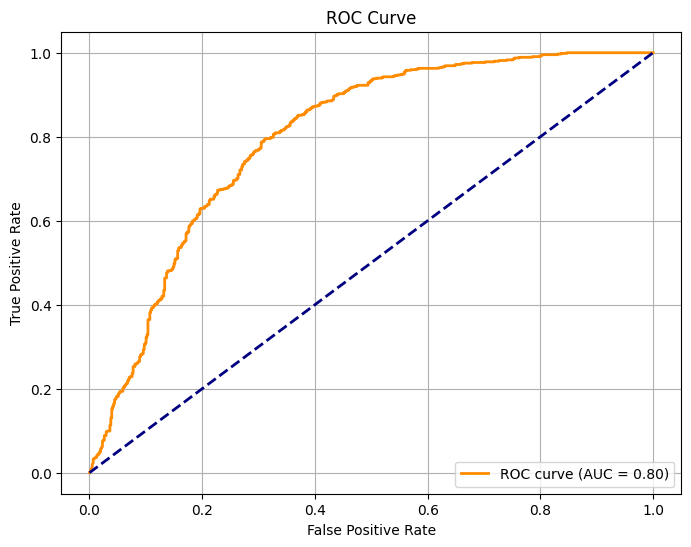

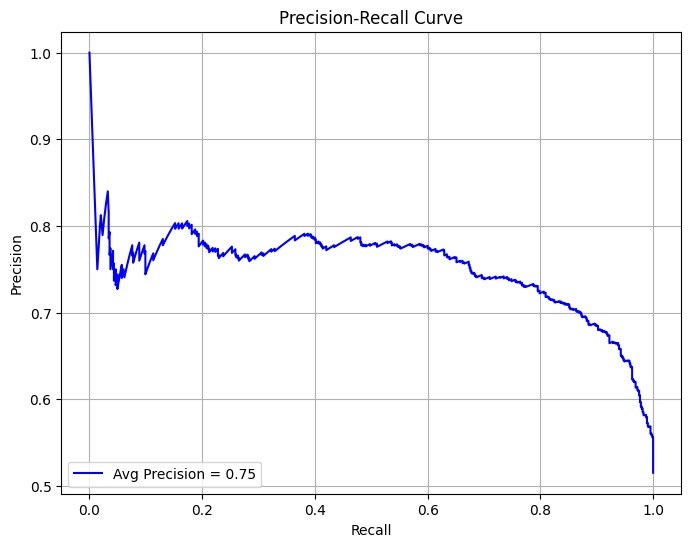

In [10]:
# Let's implemment in the neural networking part

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import pickle

# Let's implement the neural networking part


# Validate input shapes
assert len(X_train.shape) == 2, "X_train should be 2D"
assert len(y_train.shape) == 1 or y_train.shape[1] == 1, "y_train should be 1D or a column vector"

# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model architecture
print(model.summary())

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# Predict on test set
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Sensitivity (Recall for class 1)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity:", sensitivity)

# Specificity
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificity)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Save the model
model.save("neural_network_model.h5")